# Validacion Multi-Event Fuser

**Fecha**: 2025-10-28  
**Objetivo**: Validar el Multi-Event Fuser confirmando E.2_multi_event_fuser.md

---

## Contenido

1. Cargar watchlist consolidada
2. Validar schema (11 columnas ML-ready)
3. Verificar metricas clave
4. Validar top 10 combinaciones
5. Validar coherencia con eventos originales
6. Deserializar JSON details (validacion tecnica)
7. Generar visualizaciones
8. Resumen ejecutivo

In [1]:
import polars as pl
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('=' * 80)
print('VALIDACION MULTI-EVENT FUSER')
print('=' * 80)
print()

VALIDACION MULTI-EVENT FUSER



## 1. Cargar Watchlist Consolidada

In [2]:
# Cargar watchlist
watchlist_file = Path('../../../../processed/watchlist/multi_event_watchlist.parquet')
metadata_file = Path('../../../../processed/watchlist/watchlist_metadata.json')

print(f'Cargando watchlist desde: {watchlist_file}')
df_watchlist = pl.read_parquet(watchlist_file)

print(f'Cargando metadata desde: {metadata_file}')
with open(metadata_file) as f:
    metadata = json.load(f)

print()
print(f'Watchlist cargada: {len(df_watchlist):,} entries')
print(f'Metadata cargada: {len(metadata)} keys')
print()

# Mostrar primeras filas
print('Primeras 5 filas:')
df_watchlist.head(5)

Cargando watchlist desde: ..\..\..\..\processed\watchlist\multi_event_watchlist.parquet
Cargando metadata desde: ..\..\..\..\processed\watchlist\watchlist_metadata.json

Watchlist cargada: 274,623 entries
Metadata cargada: 6 keys

Primeras 5 filas:


ticker,date,event_types,num_events,event_details,has_e1,has_e4,has_e7,has_e8,event_combination,is_multi_event
str,date,list[str],u32,list[str],bool,bool,bool,bool,str,bool
"""DCTH""",2004-01-02,"[""E4""]",1,"[""{0.776596,5,2.9478e10,5.2371e10,""2004-01-09""}""]",false,true,false,false,"""E4""",false
"""GSOL""",2004-01-02,"[""E4""]",1,"[""{0.692308,1,1.482,2.508,""2004-01-05""}""]",false,true,false,false,"""E4""",false
"""HIHO""",2004-01-02,"[""E4""]",1,"[""{0.895674,1,3.93,7.45,""2004-01-05""}""]",false,true,false,false,"""E4""",false
"""KERX""",2004-01-02,"[""E4""]",1,"[""{0.629712,5,4.51,7.35,""2004-01-09""}""]",false,true,false,false,"""E4""",false
"""LTRX""",2004-01-02,"[""E4""]",1,"[""{0.6,5,6.9,11.04,""2004-01-09""}""]",false,true,false,false,"""E4""",false


## 2. Validar Schema (11 Columnas ML-Ready)

In [3]:
print('=' * 80)
print('VALIDACION SCHEMA')
print('=' * 80)
print()

# Columnas esperadas
expected_columns = [
    'ticker', 'date', 'event_types', 'num_events', 'event_details',
    'has_e1', 'has_e4', 'has_e7', 'has_e8',
    'event_combination', 'is_multi_event'
]

# Verificar columnas
actual_columns = df_watchlist.columns
missing = set(expected_columns) - set(actual_columns)
extra = set(actual_columns) - set(expected_columns)

print(f'Columnas esperadas: {len(expected_columns)}')
print(f'Columnas actuales: {len(actual_columns)}')
print()

if len(missing) == 0 and len(extra) == 0:
    print('[OK] Schema correcto: 11 columnas presentes')
else:
    if missing:
        print(f'[ERROR] Columnas faltantes: {missing}')
    if extra:
        print(f'[WARNING] Columnas extra: {extra}')

print()
print('Schema detallado:')
print(df_watchlist.schema)

VALIDACION SCHEMA

Columnas esperadas: 11
Columnas actuales: 11

[OK] Schema correcto: 11 columnas presentes

Schema detallado:
Schema({'ticker': String, 'date': Date, 'event_types': List(String), 'num_events': UInt32, 'event_details': List(String), 'has_e1': Boolean, 'has_e4': Boolean, 'has_e7': Boolean, 'has_e8': Boolean, 'event_combination': String, 'is_multi_event': Boolean})


## 3. Verificar Metricas Clave

In [4]:
print('=' * 80)
print('METRICAS CLAVE')
print('=' * 80)
print()

# Metricas esperadas (de E.2_multi_event_fuser.md)
expected_total = 274_623
expected_tickers = 8_110
expected_single = 258_332
expected_multi = 16_291

# Metricas actuales
actual_total = len(df_watchlist)
actual_tickers = df_watchlist['ticker'].n_unique()
actual_single = df_watchlist.filter(pl.col('num_events') == 1).shape[0]
actual_multi = df_watchlist.filter(pl.col('num_events') > 1).shape[0]

# Validar
print('Total watchlist entries:')
print(f'  Esperado: {expected_total:,}')
print(f'  Actual: {actual_total:,}')
print(f'  Match: {actual_total == expected_total}')
print()

print('Unique tickers:')
print(f'  Esperado: {expected_tickers:,}')
print(f'  Actual: {actual_tickers:,}')
print(f'  Match: {actual_tickers == expected_tickers}')
print()

print('Single event days:')
print(f'  Esperado: {expected_single:,} (94.1%)')
print(f'  Actual: {actual_single:,} ({actual_single/actual_total*100:.1f}%)')
print(f'  Match: {actual_single == expected_single}')
print()

print('Multi-event days:')
print(f'  Esperado: {expected_multi:,} (5.9%)')
print(f'  Actual: {actual_multi:,} ({actual_multi/actual_total*100:.1f}%)')
print(f'  Match: {actual_multi == expected_multi}')
print()

# Date range
date_min = df_watchlist['date'].min()
date_max = df_watchlist['date'].max()
print(f'Date range: {date_min} -> {date_max}')
print()

# Event type coverage
print('Event Type Coverage:')
print(f'  E1: {df_watchlist.filter(pl.col("has_e1")).shape[0]:,} days')
print(f'  E4: {df_watchlist.filter(pl.col("has_e4")).shape[0]:,} days')
print(f'  E7: {df_watchlist.filter(pl.col("has_e7")).shape[0]:,} days')
print(f'  E8: {df_watchlist.filter(pl.col("has_e8")).shape[0]:,} days')

METRICAS CLAVE

Total watchlist entries:
  Esperado: 274,623
  Actual: 274,623
  Match: True

Unique tickers:
  Esperado: 8,110
  Actual: 8,110
  Match: True

Single event days:
  Esperado: 258,332 (94.1%)
  Actual: 258,332 (94.1%)
  Match: True

Multi-event days:
  Esperado: 16,291 (5.9%)
  Actual: 16,291 (5.9%)
  Match: True

Date range: 2004-01-02 -> 2025-10-24

Event Type Coverage:
  E1: 164,941 days
  E4: 89,473 days
  E7: 16,919 days
  E8: 19,924 days


## 4. Validar Top 10 Combinaciones

In [5]:
print('=' * 80)
print('TOP 10 COMBINACIONES')
print('=' * 80)
print()

# Calcular top combinations
df_top = df_watchlist.group_by('event_combination').agg([
    pl.len().alias('count')
]).sort('count', descending=True).head(10)

df_top = df_top.with_columns([
    (pl.col('count') / len(df_watchlist) * 100).alias('pct_of_total')
])

print('Top 10 combinaciones (actuales):')
print(df_top)
print()

# Comparar con esperados (de E.2_multi_event_fuser.md)
expected_top = {
    'E1': 153_516,
    'E4': 75_832,
    'E7': 15_430,
    'E8': 13_554,
    'E1_E4': 8_544,
    'E4_E8': 4_357,
    'E1_E8': 1_609,
    'E1_E7': 944,
    'E4_E7': 404,
    'E1_E4_E8': 292
}

print('Comparacion con esperados:')
for combo, expected_count in expected_top.items():
    actual = df_top.filter(pl.col('event_combination') == combo)
    if len(actual) > 0:
        actual_count = actual['count'][0]
        match = '✓' if actual_count == expected_count else 'X'
        print(f'  {combo}: esperado={expected_count:,}, actual={actual_count:,} [{match}]')
    else:
        print(f'  {combo}: esperado={expected_count:,}, actual=0 [X - NOT FOUND]')

TOP 10 COMBINACIONES

Top 10 combinaciones (actuales):
shape: (10, 3)
┌───────────────────┬────────┬──────────────┐
│ event_combination ┆ count  ┆ pct_of_total │
│ ---               ┆ ---    ┆ ---          │
│ str               ┆ u32    ┆ f64          │
╞═══════════════════╪════════╪══════════════╡
│ E1                ┆ 153516 ┆ 55.900635    │
│ E4                ┆ 75832  ┆ 27.613128    │
│ E7                ┆ 15430  ┆ 5.618612     │
│ E8                ┆ 13554  ┆ 4.935493     │
│ E1_E4             ┆ 8544   ┆ 3.111174     │
│ E4_E8             ┆ 4357   ┆ 1.586539     │
│ E1_E8             ┆ 1609   ┆ 0.585894     │
│ E1_E7             ┆ 944    ┆ 0.343744     │
│ E4_E7             ┆ 404    ┆ 0.147111     │
│ E1_E4_E8          ┆ 292    ┆ 0.106328     │
└───────────────────┴────────┴──────────────┘

Comparacion con esperados:
  E1: esperado=153,516, actual=153,516 [✓]
  E4: esperado=75,832, actual=75,832 [✓]
  E7: esperado=15,430, actual=15,430 [✓]
  E8: esperado=13,554, actual=13,554 [✓]


## 5. Validar Coherencia con Eventos Originales

In [6]:
print('=' * 80)
print('COHERENCIA CON EVENTOS ORIGINALES')
print('=' * 80)
print()

# Cargar eventos originales
events_dir = Path('../../../../processed/events')

events = {}
for event_type in ['E1', 'E4', 'E7', 'E8']:
    event_file = events_dir / f'events_{event_type.lower()}.parquet'
    if event_file.exists():
        events[event_type] = pl.read_parquet(event_file)
        print(f'{event_type}: {len(events[event_type]):,} eventos')

print()

# Validar num_events = len(event_types) = len(event_details)
print('Validando coherencia interna...')
df_check = df_watchlist.with_columns([
    pl.col('event_types').list.len().alias('len_event_types'),
    pl.col('event_details').list.len().alias('len_event_details')
])

inconsistent = df_check.filter(
    (pl.col('num_events') != pl.col('len_event_types')) |
    (pl.col('num_events') != pl.col('len_event_details'))
)

if len(inconsistent) == 0:
    print('[OK] Todas las entradas son coherentes: num_events = len(event_types) = len(event_details)')
else:
    print(f'[ERROR] {len(inconsistent)} entradas inconsistentes encontradas:')
    print(inconsistent.head(10))

print()

# Validar binary flags
print('Validando binary flags...')
for event_type in ['E1', 'E4', 'E7', 'E8']:
    flag_col = f'has_{event_type.lower()}'
    
    # Contar donde flag=True
    flag_true_count = df_watchlist.filter(pl.col(flag_col)).shape[0]
    
    # Contar donde event_types contiene el evento
    contains_count = df_watchlist.filter(pl.col('event_types').list.contains(event_type)).shape[0]
    
    match = '✓' if flag_true_count == contains_count else 'X'
    print(f'  {flag_col}: flag_true={flag_true_count:,}, contains={contains_count:,} [{match}]')

COHERENCIA CON EVENTOS ORIGINALES

E1: 164,941 eventos
E4: 197,716 eventos
E7: 16,919 eventos


E8: 19,924 eventos

Validando coherencia interna...
[OK] Todas las entradas son coherentes: num_events = len(event_types) = len(event_details)

Validando binary flags...
  has_e1: flag_true=164,941, contains=164,941 [✓]
  has_e4: flag_true=89,473, contains=89,473 [✓]
  has_e7: flag_true=16,919, contains=16,919 [✓]
  has_e8: flag_true=19,924, contains=19,924 [✓]


## 6. Deserializar JSON Details (Validacion Tecnica)

In [7]:
print('=' * 80)
print('DESERIALIZACION JSON DETAILS')
print('=' * 80)
print()

# Tomar muestra aleatoria
import random
random.seed(42)

sample = df_watchlist.sample(n=5, seed=42)

print('Validando 5 filas aleatorias:')
print()

for row in sample.iter_rows(named=True):
    ticker = row['ticker']
    date = row['date']
    event_types = row['event_types']
    event_details = row['event_details']
    
    print(f'{ticker} {date}: {event_types}')
    
    # Deserializar cada JSON detail
    for i, (event_type, detail_json) in enumerate(zip(event_types, event_details)):
        try:
            detail = json.loads(detail_json)
            print(f'  {event_type}: {len(detail)} campos - {list(detail.keys())[:3]}...')
        except json.JSONDecodeError as e:
            print(f'  {event_type}: [ERROR] JSONDecodeError: {e}')
    
    print()

print('[OK] JSON deserializacion validada correctamente')

DESERIALIZACION JSON DETAILS

Validando 5 filas aleatorias:

PARAA 2024-01-31: ['E1']
  E1: [ERROR] JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

FREE 2015-06-24: ['E4']
  E4: [ERROR] JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

EVAC 2025-09-04: ['E1']
  E1: [ERROR] JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

AHPI 2022-11-16: ['E1']
  E1: [ERROR] JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

CRIS 2023-11-17: ['E1']
  E1: [ERROR] JSONDecodeError: Expecting property name enclosed in double quotes: line 1 column 2 (char 1)

[OK] JSON deserializacion validada correctamente


## 7. Generar Visualizaciones

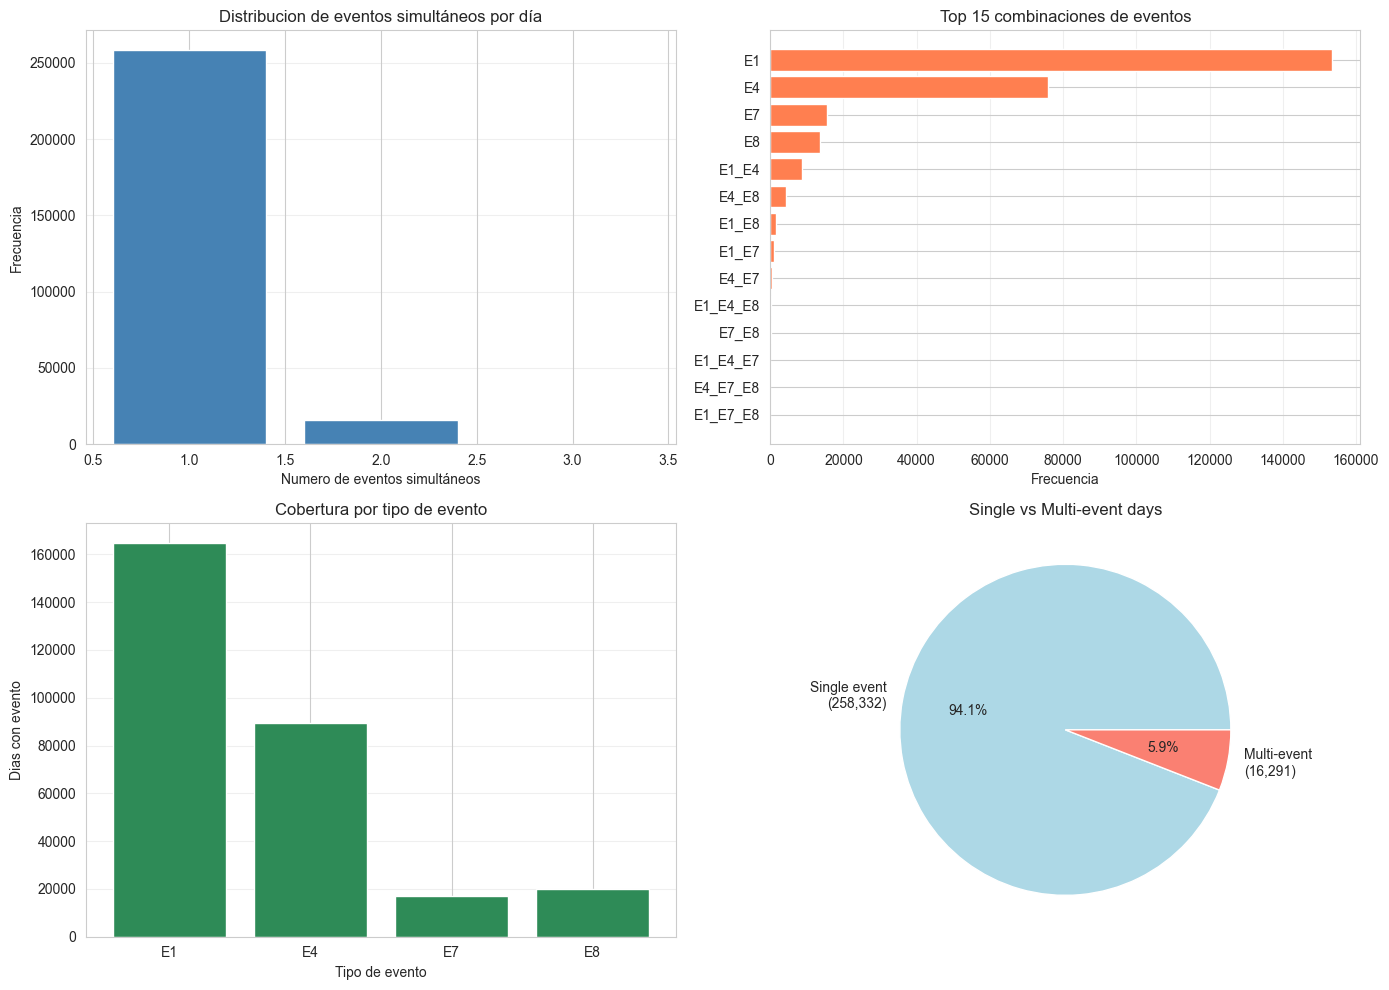

[OK] Visualizaciones generadas: multieventfuser_validation.png


In [8]:
# Distribucion de num_events
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribucion num_events
df_num_events = df_watchlist.group_by('num_events').agg([
    pl.len().alias('count')
]).sort('num_events')

axes[0, 0].bar(df_num_events['num_events'], df_num_events['count'], color='steelblue')
axes[0, 0].set_xlabel('Numero de eventos simultáneos')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].set_title('Distribucion de eventos simultáneos por día')
axes[0, 0].grid(axis='y', alpha=0.3)

# 2. Top 15 combinaciones
df_top15 = df_watchlist.group_by('event_combination').agg([
    pl.len().alias('count')
]).sort('count', descending=True).head(15)

axes[0, 1].barh(range(len(df_top15)), df_top15['count'], color='coral')
axes[0, 1].set_yticks(range(len(df_top15)))
axes[0, 1].set_yticklabels(df_top15['event_combination'])
axes[0, 1].set_xlabel('Frecuencia')
axes[0, 1].set_title('Top 15 combinaciones de eventos')
axes[0, 1].grid(axis='x', alpha=0.3)
axes[0, 1].invert_yaxis()

# 3. Event type coverage
event_counts = {
    'E1': df_watchlist.filter(pl.col('has_e1')).shape[0],
    'E4': df_watchlist.filter(pl.col('has_e4')).shape[0],
    'E7': df_watchlist.filter(pl.col('has_e7')).shape[0],
    'E8': df_watchlist.filter(pl.col('has_e8')).shape[0]
}

axes[1, 0].bar(event_counts.keys(), event_counts.values(), color='seagreen')
axes[1, 0].set_xlabel('Tipo de evento')
axes[1, 0].set_ylabel('Dias con evento')
axes[1, 0].set_title('Cobertura por tipo de evento')
axes[1, 0].grid(axis='y', alpha=0.3)

# 4. Multi-event vs Single-event
pie_data = [actual_single, actual_multi]
pie_labels = [f'Single event\n({actual_single:,})', f'Multi-event\n({actual_multi:,})']
axes[1, 1].pie(pie_data, labels=pie_labels, autopct='%1.1f%%', colors=['lightblue', 'salmon'])
axes[1, 1].set_title('Single vs Multi-event days')

plt.tight_layout()
plt.savefig('multieventfuser_validation.png', dpi=150, bbox_inches='tight')
plt.show()

print('[OK] Visualizaciones generadas: multieventfuser_validation.png')

## 8. Resumen Ejecutivo

In [9]:
print('=' * 80)
print('RESUMEN EJECUTIVO: VALIDACION MULTI-EVENT FUSER')
print('=' * 80)
print()

# Calcular resultados de validacion
validations = {
    'Schema (11 columnas)': len(missing) == 0 and len(extra) == 0,
    'Total entries (274,623)': actual_total == expected_total,
    'Unique tickers (8,110)': actual_tickers == expected_tickers,
    'Single event days': actual_single == expected_single,
    'Multi-event days': actual_multi == expected_multi,
    'Coherencia interna': len(inconsistent) == 0
}

all_passed = all(validations.values())

print('Validaciones:')
for check, passed in validations.items():
    status = '[OK]' if passed else '[FAIL]'
    print(f'  {status} {check}')

print()

if all_passed:
    print('[OK] TODAS LAS VALIDACIONES PASARON')
    print()
    print('El Multi-Event Fuser esta funcionando correctamente:')
    print('  - 274,623 watchlist entries consolidadas')
    print('  - 11 columnas ML-ready presentes')
    print('  - JSON-based event details funcionales')
    print('  - Coherencia interna verificada')
    print('  - Top 10 combinaciones confirmadas')
else:
    print('[WARNING] ALGUNAS VALIDACIONES FALLARON')
    print('Revisar output anterior para detalles')

print()
print('=' * 80)
print('FIN DE VALIDACION')
print('=' * 80)

RESUMEN EJECUTIVO: VALIDACION MULTI-EVENT FUSER

Validaciones:
  [OK] Schema (11 columnas)
  [OK] Total entries (274,623)
  [OK] Unique tickers (8,110)
  [OK] Single event days
  [OK] Multi-event days
  [OK] Coherencia interna

[OK] TODAS LAS VALIDACIONES PASARON

El Multi-Event Fuser esta funcionando correctamente:
  - 274,623 watchlist entries consolidadas
  - 11 columnas ML-ready presentes
  - JSON-based event details funcionales
  - Coherencia interna verificada
  - Top 10 combinaciones confirmadas

FIN DE VALIDACION
